### `list_attr_celeba` Dataset
A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).



- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image

You can obtain the dataset from https://www.kaggle.com/jessicali9530/celeba-dataset

In [1]:
!pip install torch torchvision

In [2]:
import os
import random
import pandas as pd
from PIL import Image

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
from torchvision import models, transforms
from sklearn.model_selection import train_test_split

In [5]:
mypath = "Downloads/celeb_small 2-20251231T162021Z-1-001/celeb_small 2"

In [6]:
valid_ext = (".jpg", ".jpeg", ".png")

filenames = [
    f for f in os.listdir(mypath)
    if f.lower().endswith(valid_ext)
]

In [7]:
categories = []
for filename in filenames:
    label = filename.split('.')[0]
    if label == 'man':
        categories.append('man')
    else:
        categories.append('female')

In [8]:
df = pd.DataFrame({'file_name': filenames,
                   'category': categories
                  })

In [9]:
df['category'].value_counts()

category
female    1909
man       1892
Name: count, dtype: int64

<Axes: xlabel='category'>

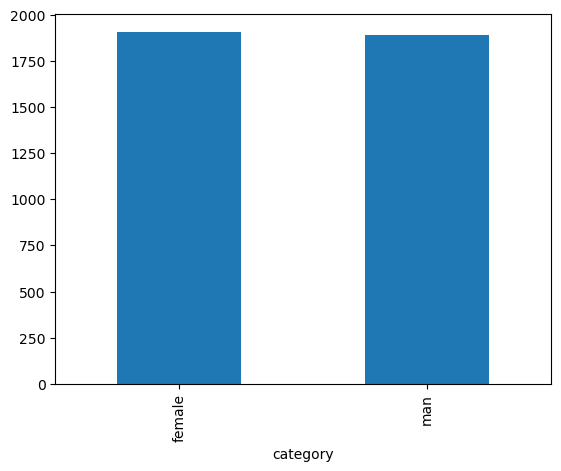

In [10]:
df['category'].value_counts().plot.bar()

In [11]:
train_df, val_df = train_test_split(df, 
                                    test_size = 0.2,
                                    stratify = df['category'],
                                    random_state = 42)

In [12]:
train_df = train_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True)

In [13]:
class GenderDataset(Dataset):
    def __init__(self, df, img_dir, transform = None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {'female':0, 'man':1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        
        img_path = os.path.join(self.img_dir, row['file_name'])
        image = Image.open(img_path).convert('RGB')
        
        label = self.label_map[row['category']]

        if self.transform:
            image = self.transform(image)

        return image, label

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((178,218)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [15]:
val_transform = transforms.Compose([
    transforms.Resize((178,218)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [16]:
train_dataset = GenderDataset(train_df, mypath, train_transform)
val_dataset = GenderDataset(val_df, mypath, val_transform)

In [17]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = True)

In [18]:
class GenderVGG(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()

        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        for param in vgg.features.parameters():
            param.requires_grad = False

        for layer in vgg.features[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        self.features = vgg.features

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 5 * 6, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model = GenderVGG(num_classes = 2).to(device)

In [21]:
criterion = nn.CrossEntropyLoss()

In [22]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr = 1e-4
)

In [23]:
epochs = 3

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss = train_loss + loss.item()
        correct = correct + (outputs.argmax(1) == labels).sum().item()
        total = total + labels.size(0)

    train_acc = correct/total

    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            val_correct = val_correct + (outputs.argmax(1) == labels).sum().item()
            val_total = val_total + labels.size(0)

    val_acc = val_correct/val_total

    print(
        f'Epoch {epoch + 1}/{epochs} |'
        f'Train Accuracy: {train_acc:.4f} |'
        f'Val Accuracy: {val_acc:.4f}'
    )

Epoch 1/3 |Train Accuracy: 0.8753 |Val Accuracy: 0.9120
Epoch 2/3 |Train Accuracy: 0.9145 |Val Accuracy: 0.9172
Epoch 3/3 |Train Accuracy: 0.9339 |Val Accuracy: 0.9120
